In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats
import os

from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [2]:
import tensorflow as tf
tf.__version__
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models

In [3]:
#Load in a model saved from server - should be near best
m = tf.keras.models.load_model('/drive/MyDrive/Colab Notebooks/Thesis Notebooks/wholeBestModel')


In [4]:
def getDataGen(tfrecordPaths, shuffle=False):
    def decode(serialized_example):
            features = {
                "feature0": tf.io.FixedLenFeature([32000,1], tf.float32),
                "label": tf.io.FixedLenFeature([], tf.int64),
         }
            example = tf.io.parse_single_example(serialized_example, features)

            feature0 = example['feature0']
            label = example['label']
            return (feature0,
                    label)
    
    dataset = tf.data.TFRecordDataset(tfrecordPaths)
    dataset = dataset.map(decode) 
    if shuffle==True:
      dataset = dataset.shuffle(8000) #This ensures all data is shuffled before being outputted
    return dataset

tfRecordsDir = "/drive/MyDrive/Colab Notebooks/Thesis Notebooks/testData/"
testDataFiles = (tfRecordsDir+"fold10/ubs.tfRecord_0",tfRecordsDir+"fold10/ubs.tfRecord_1")
datasetTest = getDataGen(testDataFiles) #datasetTest contains 837 elements, this remains unchanged
batchTest = datasetTest.batch(400, drop_remainder=False)


In [5]:
x_test, y_test = list(datasetTest.batch(1000))[0] #We just take 1000 cuz it's bigger than test set size
x_test = x_test.numpy()
y_test = y_test.numpy()

m.evaluate(x = x_test, y = y_test) #Single MC sample

27/27 [==============================] - 17s 548ms/step - loss: 2554.8491 - accuracy: 0.4480


[2554.84912109375, 0.44802868366241455]

In [6]:
def plotRejectionClassificationEnt(m, x_test, y_test, mcSampleNo = 1, T = 1):
    """ First we'll plot the model accuracy against percentage of preds dropped from the highest uncertainties.
        1) First we will find the probs.
        2) Assign an uncertainty score to each
        3) Calculate whether each test example was calculated correctly
        4) Remove x% of the examples and calculate the accuracy on the remainder.
            Do this for a range of x from 0 to 100.
        5) Plot x against accuracy
    Then we will plot the theoretical max, where all the incorrect predictions are dropped first
        1) Sort comp according to whether the prediction is right or wrong.
        2) Filter out the wrong preds first, calculate acc as before.
        3) plot as before
    """
    listEnts = []
    for t in range(T): #We're going to average over more than one prediction output (each output being an average of mcSampleNo)
      y_probs = np.mean(np.array([m(x_test).numpy() for i in range(mcSampleNo)]), axis=0)
      comp = np.argmax(y_probs, axis=1) == y_test
      subEnt = -np.sum(y_probs * np.log2(y_probs), axis=1)
      listEnts.append(subEnt)
    
    entropy = np.mean(listEnts, axis=0) #Now we have an average ent over more than one prediction

    entSortedList = sorted(np.array([entropy, comp]).T, key=lambda x: x[0]) #Put entropies and correct/incorr in an array and sort according to entropy
    correctSortedList = sorted(np.array([entropy, comp]).T, key=lambda x: x[1], reverse = True) #Sort on correct predictions

    totalNum = len(entSortedList)
    pcents = np.arange(0, 100, 1)
    accsEnt = []
    accsCorr = []
    for pcent in pcents:
      subNum = int(totalNum * (1-pcent/100))

      accEnt = np.sum(entSortedList[:subNum], axis=0)[1]/subNum
      accsEnt.append(accEnt)

      accCorr = np.sum(correctSortedList[:subNum], axis=0)[1]/subNum
      accsCorr.append(accCorr)
    df = pd.DataFrame()
    maxData = pd.DataFrame({"Percentage of the data rejected by uncertainty":np.arange(0, 100, 1), "Accuracy":accsCorr, "Type":"Theoretical Maximum"})
    df = df.append(maxData)
    modelData = pd.DataFrame({"Percentage of the data rejected by uncertainty":np.arange(0, 100, 1), "Accuracy":accsEnt, "Type":"M18-P"})
    df = df.append(modelData,  ignore_index=True)

    p = sns.relplot(data=df, x = "Percentage of the data rejected by uncertainty", y = "Accuracy", kind = "line", hue = "Type")
    p.map(plt.axhline, y=0.7168, color=".3", dashes=(2, 1), zorder=0, label="Deterministic M18 Test Accuracy")
    #plt.plot([0, 100], [0.7168, 0.7168], "--", label = "Deterministic M18 Test Accuracy")
    #plt.legend()
    plt.grid()
    plt.show;

    txt = "The probabilistic M18-P surpasses the performance of deterministic M18 by rejecting the most uncertain {:1}% of predictions, where uncertainty is measured using predictive entropy"
    for i in range(100):
      if np.array(accsEnt[i])>0.7168:
        print(txt.format(i) )
        break
        
    return accsCorr, accsEnt



In [7]:
def plotRejectionClassificationEnt(m, x_test, y_test, T = 10):
    """ First we'll plot the model accuracy against percentage of preds dropped from the highest uncertainties.
        1) First we will find the probs.
        2) Assign an uncertainty score to each
        3) Calculate whether each test example was calculated correctly
        4) Remove x% of the examples and calculate the accuracy on the remainder.
            Do this for a range of x from 0 to 100.
        5) Plot x against accuracy
    Then we will plot the theoretical max, where all the incorrect predictions are dropped first
        1) Sort comp according to whether the prediction is right or wrong.
        2) Filter out the wrong preds first, calculate acc as before.
        3) plot as before
    """
    listEnts = []
    y_probs = np.mean(np.array([m(x_test).numpy() for i in range(T)]), axis=0)
    comp = np.argmax(y_probs, axis=1) == y_test
    entropy = -np.sum(y_probs * np.log2(y_probs), axis=1)

    entSortedList = sorted(np.array([entropy, comp]).T, key=lambda x: x[0]) #Put entropies and correct/incorr in an array and sort according to entropy
    correctSortedList = sorted(np.array([entropy, comp]).T, key=lambda x: x[1], reverse = True) #Sort on correct predictions

    totalNum = len(entSortedList)
    pcents = np.arange(0, 100, 1)
    accsEnt = []
    accsCorr = []
    for pcent in pcents:
      subNum = int(totalNum * (1-pcent/100))

      accEnt = np.sum(entSortedList[:subNum], axis=0)[1]/subNum
      accsEnt.append(accEnt)

      accCorr = np.sum(correctSortedList[:subNum], axis=0)[1]/subNum
      accsCorr.append(accCorr)
    df = pd.DataFrame()
    maxData = pd.DataFrame({"Percentage of the data rejected by uncertainty":np.arange(0, 100, 1), "Accuracy":accsCorr, "Type":"Theoretical Maximum"})
    df = df.append(maxData)
    modelData = pd.DataFrame({"Percentage of the data rejected by uncertainty":np.arange(0, 100, 1), "Accuracy":accsEnt, "Type":"M18-P"})
    df = df.append(modelData,  ignore_index=True)

    p = sns.relplot(data=df, x = "Percentage of the data rejected by uncertainty", y = "Accuracy", kind = "line", hue = "Type")
    p.map(plt.axhline, y=0.7168, color=".3", dashes=(2, 1), zorder=0, label="Deterministic M18 Test Accuracy")
    #plt.plot([0, 100], [0.7168, 0.7168], "--", label = "Deterministic M18 Test Accuracy")
    #plt.legend()
    plt.grid()
    plt.show;

    txt = "The probabilistic M18-P surpasses the performance of deterministic M18 by rejecting the most uncertain {:1}% of predictions, where uncertainty is measured using predictive entropy"
    for i in range(100):
      if np.array(accsEnt[i])>0.7168:
        print(txt.format(i) )
        break
        
    return accsCorr, accsEnt



The probabilistic M18-P surpasses the performance of deterministic M18 by rejecting the most uncertain 88% of predictions, where uncertainty is measured using predictive entropy


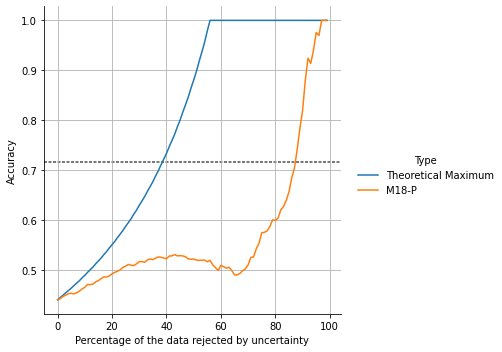

In [8]:
accsC, accsE = plotRejectionClassificationEnt(m, x_test, y_test, T = 1)

The probabilistic M18-P surpasses the performance of deterministic M18 by rejecting the most uncertain 36% of predictions, where uncertainty is measured using predictive entropy


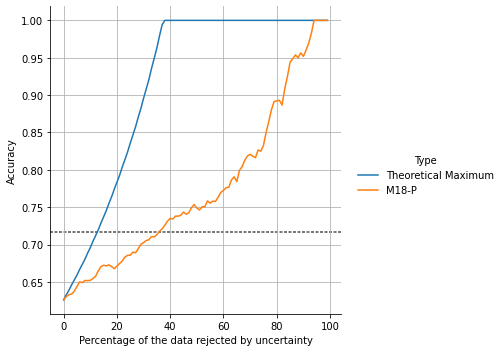

In [9]:
accsC, accsE = plotRejectionClassificationEnt(m, x_test, y_test, T = 25)

The probabilistic M18-P surpasses the performance of deterministic M18 by rejecting the most uncertain 31% of predictions, where uncertainty is measured using predictive entropy


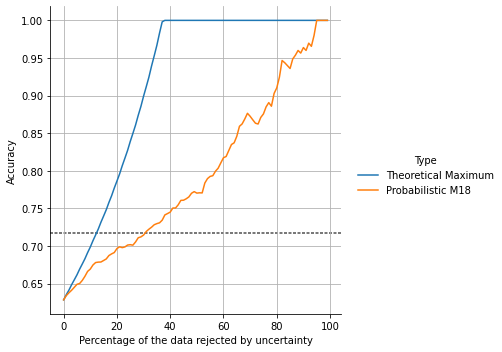

In [ ]:
accsC, accsE = plotRejectionClassificationEnt(m, x_test, y_test, T = 50)

The probabilistic M18-P surpasses the performance of deterministic M18 by rejecting the most uncertain 13% of predictions, where uncertainty is measured using predictive entropy


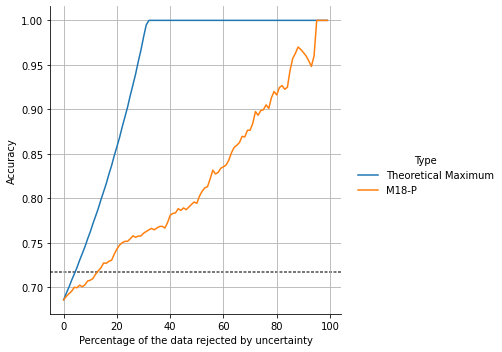

In [ ]:
accsC, accsE = plotRejectionClassificationEnt(m, x_test, y_test, T=50)

We plot the same but now using mutual information as the uncertainty measure.

In [ ]:
def plotRejectionClassificationMI(m, x_test, y_test, T = 10):
    """ First we'll plot the model accuracy against percentage of preds dropped from the highest uncertainties.
        1) First we will find the probs. Average oveer T predictions and calculate accuracy on this: predictiveEntrop
        2) Assign an uncertainty score to each prediction from all T, and average over these also: aleatoricEntropy
        3) Calculate whether each test example was calculated correctly
        4) Remove x% of the examples and calculate the accuracy on the remainder.
            Do this for a range of x from 0 to 100.
        5) Plot x against accuracy
    Then we will plot the theoretical max, where all the incorrect predictions are dropped first
        1) Sort comp according to whether the prediction is right or wrong.
        2) Filter out the wrong preds first, calculate acc as before.
        3) plot as before
    """
    listAlEnts = []
    y_probs_list = []
    for t in range(T): #We're going to average over more than one prediction output (each output being an average of mcSampleNo)
      y_probs = m(x_test).numpy()
      y_probs_list.append(y_probs)
      subEnt = -np.sum(y_probs * np.log2(y_probs), axis=1)
      listAlEnts.append(subEnt)
    
    y_probs_av = np.mean(y_probs_list, axis = 0)
    predictiveEntropy = -np.sum(y_probs_av * np.log2(y_probs_av), axis=1)
    comp = np.argmax(y_probs_av, axis=1) == y_test

    aleatoricEntropy = np.mean(listAlEnts, axis=0) #Now we have an average ent over more than one prediction
    MI = predictiveEntropy - aleatoricEntropy

    miSortedList = sorted(np.array([MI, comp]).T, key=lambda x: x[0]) #Put MIs and correct/incorr in an array and sort according to entropy
    correctSortedList = sorted(np.array([MI, comp]).T, key=lambda x: x[1], reverse = True) #Sort on correct predictions

    totalNum = len(miSortedList)
    pcents = np.arange(0, 100, 1)
    accsMi = []
    accsCorr = []
    for pcent in pcents:
      subNum = int(totalNum * (1-pcent/100))

      accMi = np.sum(miSortedList[:subNum], axis=0)[1]/subNum
      accsMi.append(accMi)

      accCorr = np.sum(correctSortedList[:subNum], axis=0)[1]/subNum
      accsCorr.append(accCorr)
    df = pd.DataFrame()
    maxData = pd.DataFrame({"Percentage of the data rejected by uncertainty":np.arange(0, 100, 1), "Accuracy":accsCorr, "Type":"Theoretical Maximum"})
    df = df.append(maxData)
    modelData = pd.DataFrame({"Percentage of the data rejected by uncertainty":np.arange(0, 100, 1), "Accuracy":accsMi, "Type":"M18-P"})
    df = df.append(modelData,  ignore_index=True)

    p = sns.relplot(data=df, x = "Percentage of the data rejected by uncertainty", y = "Accuracy", kind = "line", hue = "Type")
    p.map(plt.axhline, y=0.7168, color=".3", dashes=(2, 1), zorder=0, label="Deterministic M18 Test Accuracy")
    #plt.plot([0, 100], [0.7168, 0.7168], "--", label = "Deterministic M18 Test Accuracy")
    #plt.legend()
    plt.grid()
    plt.show;

    txt = "The probabilistic M18-P surpasses the performance of deterministic M18 by rejecting the most uncertain {:1}% of predictions, where uncertainty is measured using predictive entropy"
    for i in range(100):
      if np.array(accsMi[i])>0.7168:
        print(txt.format(i) )
        break
        
    #return accsCorr, accsMi



The probabilistic M18-P surpasses the performance of deterministic M18 by rejecting the most uncertain 94% of predictions, where uncertainty is measured using predictive entropy


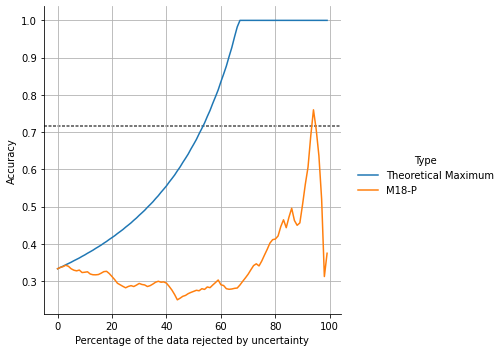

In [ ]:
plotRejectionClassificationMI(m, x_test, y_test, T=1)

The probabilistic M18-P surpasses the performance of deterministic M18 by rejecting the most uncertain 43% of predictions, where uncertainty is measured using predictive entropy


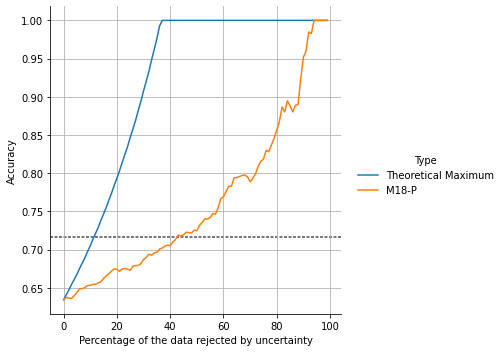

In [ ]:
plotRejectionClassificationMI(m, x_test, y_test, T=25)

The probabilistic M18-P surpasses the performance of deterministic M18 by rejecting the most uncertain 32% of predictions, where uncertainty is measured using predictive entropy


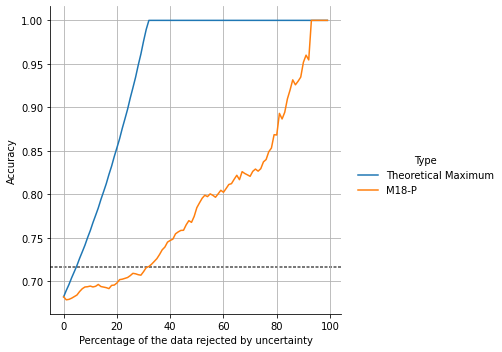

In [ ]:
plotRejectionClassificationMI(m, x_test, y_test, T=50)

The probabilistic M18-P surpasses the performance of deterministic M18 by rejecting the most uncertain 28% of predictions, where uncertainty is measured using predictive entropy


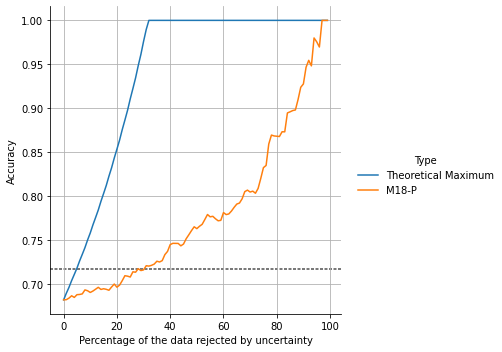

In [ ]:
plotRejectionClassificationMI(m, x_test, y_test, T=100)

Do with aleatoric entropy next.

In [ ]:
def plotRejectionClassificationAvEnt(m, x_test, y_test, T = 10):
    """ First we'll plot the model accuracy against percentage of preds dropped from the highest uncertainties.
        1) First we will find the probs.
        2) Assign an uncertainty score to each
        3) Calculate whether each test example was calculated correctly
        4) Remove x% of the examples and calculate the accuracy on the remainder.
            Do this for a range of x from 0 to 100.
        5) Plot x against accuracy
    Then we will plot the theoretical max, where all the incorrect predictions are dropped first
        1) Sort comp according to whether the prediction is right or wrong.
        2) Filter out the wrong preds first, calculate acc as before.
        3) plot as before
    """  
    y_probs_arr = np.array([m(x_test).numpy() for i in range(T)])
    y_probs = np.mean(y_probs_arr, axis=0)
    comp = np.argmax(y_probs, axis=1) == y_test

    ent = -np.sum(y_probs * np.log2(y_probs), axis=1) #Entropy of the average predicted probs
    avEnt = np.mean([-np.sum(y_ps * np.log2(y_ps), axis=1) for y_ps in y_probs_arr], axis = 0) 

    mis = ent - avEnt

    avEntSortedList = sorted(np.array([avEnt, comp]).T, key=lambda x: x[0]) #Put mutual informations and correct/incorr in an array and sort according to mutual info score
    correctSortedList = sorted(np.array([avEnt, comp]).T, key=lambda x: x[1], reverse = True) #Sort on correct predictions

    totalNum = len(avEntSortedList)
    pcents = np.arange(0, 100, 1)
    accsAvEnt = []
    accsCorr = []
    for pcent in pcents:
      subNum = int(totalNum * (1-pcent/100))

      accAvEnt = np.sum(avEntSortedList[:subNum], axis=0)[1]/subNum
      accsAvEnt.append(accAvEnt)

      accCorr = np.sum(correctSortedList[:subNum], axis=0)[1]/subNum
      accsCorr.append(accCorr)
    df = pd.DataFrame()
    maxData = pd.DataFrame({"Percentage of the data rejected by uncertainty":np.arange(0, 100, 1), "Accuracy":accsCorr, "Type":"Theoretical Maximum"})
    df = df.append(maxData)
    modelData = pd.DataFrame({"Percentage of the data rejected by uncertainty":np.arange(0, 100, 1), "Accuracy":accsAvEnt, "Type":"M18-P"})
    df = df.append(modelData,  ignore_index=True)

    p = sns.relplot(data=df, x = "Percentage of the data rejected by uncertainty", y = "Accuracy", kind = "line", hue = "Type")
    p.map(plt.axhline, y=0.7168, color=".3", dashes=(2, 1), zorder=0, label="Deterministic M18 Test Accuracy")
    #plt.plot([0, 100], [0.7168, 0.7168], "--", label = "Deterministic M18 Test Accuracy")
    #plt.legend()
    plt.grid()
    plt.show;

    txt = "The probabilistic M18-P surpasses the performance of deterministic M18 by rejecting the most uncertain {:1}% of predictions, where uncertainty is measured using predictive entropy"
    for i in range(100):
      if np.array(accsAvEnt[i])>0.7168:
        print(txt.format(i) )
        break
        


The probabilistic M18-P surpasses the performance of deterministic M18 by rejecting the most uncertain 68% of predictions, where uncertainty is measured using predictive entropy


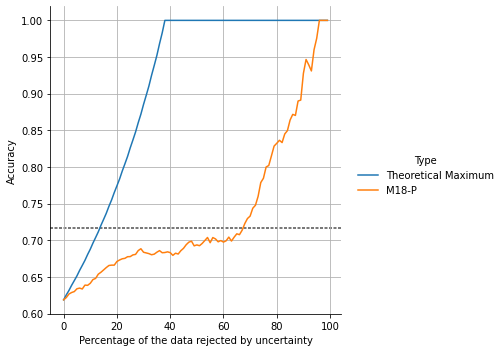

In [ ]:
plotRejectionClassificationAvEnt(m, x_test, y_test, T=30)

We plot all three simultaneously here

In [31]:
def plotRejectionClassifications(m, x_test, y_test, T = 10):
    """ First we'll plot the model accuracy against percentage of preds dropped from the highest uncertainties.
        1) First we will find the probs.
        2) Assign all three uncertainty scores to each
        3) Calculate whether each test example was calculated correctly
        4) Remove x% of the examples and calculate the accuracy on the remainder.
            Do this for a range of x from 0 to 100.
        5) Plot x against accuracy
    Then we will plot the theoretical max, where all the incorrect predictions are dropped first
        1) Sort comp according to whether the prediction is right or wrong.
        2) Filter out the wrong preds first, calculate acc as before.
        3) plot as before
    """  
    y_probs_arr = np.array([m(x_test).numpy() for i in range(T)])
    y_probs = np.mean(y_probs_arr, axis=0)
    comp = np.argmax(y_probs, axis=1) == y_test

    ent = -np.sum(y_probs * np.log2(y_probs), axis=1) #Entropy of the average predicted probs
    avEnt = np.mean([-np.sum(y_ps * np.log2(y_ps), axis=1) for y_ps in y_probs_arr], axis = 0) 

    mi = ent - avEnt

    entSortedList = sorted(np.array([ent, comp]).T, key=lambda x: x[0]) #Put entropies and correct/incorr in an array and sort according to entropy
    avEntSortedList = sorted(np.array([avEnt, comp]).T, key=lambda x: x[0]) #Put mutual informations and correct/incorr in an array and sort according to mutual info score
    miSortedList = sorted(np.array([mi, comp]).T, key=lambda x: x[0]) #Put MIs and correct/incorr in an array and sort according to entropy

    correctSortedList = sorted(np.array([avEnt, comp]).T, key=lambda x: x[1], reverse = True) #Sort on correct predictions

    totalNum = len(avEntSortedList)
    pcents = np.arange(0, 100, 1)
    
    accsEnt = []
    accsAvEnt = []
    accsMi = []
    accsCorr = []
    for pcent in pcents:
      subNum = int(totalNum * (1-pcent/100))

      accEnt = np.sum(entSortedList[:subNum], axis=0)[1]/subNum
      accsEnt.append(accEnt)
      
      accAvEnt = np.sum(avEntSortedList[:subNum], axis=0)[1]/subNum
      accsAvEnt.append(accAvEnt)

      accMi = np.sum(miSortedList[:subNum], axis=0)[1]/subNum
      accsMi.append(accMi)

      accCorr = np.sum(correctSortedList[:subNum], axis=0)[1]/subNum
      accsCorr.append(accCorr)
    df = pd.DataFrame()
    maxData = pd.DataFrame({"Percentage of the data rejected":np.arange(0, 100, 1), "Accuracy":accsCorr, "Type":"Theoretical Maximum"})
    df = df.append(maxData)
    
    entData = pd.DataFrame({"Percentage of the data rejected":np.arange(0, 100, 1), "Accuracy":accsEnt, "Type":"Predictive Entropy"})
    df = df.append(entData,  ignore_index=True)
    
    avEntData = pd.DataFrame({"Percentage of the data rejected":np.arange(0, 100, 1), "Accuracy":accsAvEnt, "Type":"Aleatoric Entropy"})
    df = df.append(avEntData,  ignore_index=True)

    miData = pd.DataFrame({"Percentage of the data rejected":np.arange(0, 100, 1), "Accuracy":accsMi, "Type":"Mutual Information"})
    df = df.append(miData,  ignore_index=True)

    p = sns.relplot(data=df, x = "Percentage of the data rejected", y = "Accuracy", kind = "line", hue = "Type")
    p.map(plt.axhline, y=0.7168, color=".3", dashes=(2, 1), zorder=0, label="Deterministic M18 Test Accuracy")
    #plt.plot([0, 100], [0.7168, 0.7168], "--", label = "Deterministic M18 Test Accuracy")
    #plt.legend()
    plt.grid()
    plt.show;

    txtEnt = "The probabilistic M18-P surpasses the performance of deterministic M18 by rejecting the most uncertain {:1}% of predictions, where uncertainty is measured using predictive entropy"
    txtAvEnt = "The probabilistic M18-P surpasses the performance of deterministic M18 by rejecting the most uncertain {:1}% of predictions, where uncertainty is measured using aleatoric entropy"
    txtMi = "The probabilistic M18-P surpasses the performance of deterministic M18 by rejecting the most uncertain {:1}% of predictions, where uncertainty is measured using mutual information"
    txtPerf = "The probabilistic M18-P would ideally surpass the performance of deterministic M18 by rejecting the most {:1}% of predictions. This is the theoretical minimum."
    for i in range(100):
      if np.array(accsEnt[i])>0.7168:
        print(txtEnt.format(i) )
        break
    for i in range(100):
      if np.array(accsAvEnt[i])>0.7168:
        print(txtAvEnt.format(i) )
        break
    for i in range(100):
      if np.array(accsMi[i])>0.7168:
        print(txtMi.format(i) )
        break
    for i in range(100):
      if np.array(accsCorr[i])>0.7168:
        print(txtPerf.format(i) )
        break

    return 

The probabilistic M18-P surpasses the performance of deterministic M18 by rejecting the most uncertain 37% of predictions, where uncertainty is measured using predictive entropy
The probabilistic M18-P surpasses the performance of deterministic M18 by rejecting the most uncertain 60% of predictions, where uncertainty is measured using aleatoric entropy
The probabilistic M18-P surpasses the performance of deterministic M18 by rejecting the most uncertain 44% of predictions, where uncertainty is measured using mutual information
The probabilistic M18-P surpasses the performance of deterministic M18 by rejecting the most uncertain 14% of predictions, where uncertainty is measured using mutual information


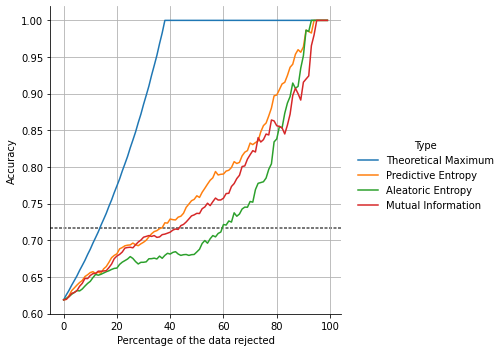

In [21]:
plotRejectionClassifications(m, x_test, y_test, T=20)

The probabilistic M18-P surpasses the performance of deterministic M18 by rejecting the most uncertain 39% of predictions, where uncertainty is measured using predictive entropy
The probabilistic M18-P surpasses the performance of deterministic M18 by rejecting the most uncertain 42% of predictions, where uncertainty is measured using aleatoric entropy
The probabilistic M18-P surpasses the performance of deterministic M18 by rejecting the most uncertain 57% of predictions, where uncertainty is measured using mutual information
The probabilistic M18-P would ideally surpass the performance of deterministic M18 by rejecting the most 13% of predictions. This is the theoretical minimum.


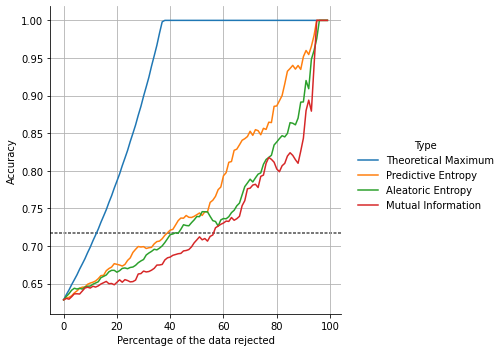

In [32]:
plotRejectionClassifications(m, x_test, y_test, T=50)